Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Generation #1 best cost: 230.61206245422363 path: [6, 13, 3, 8, 2, 9, 5, 11, 14, 7, 1, 10, 12, 4, 0]
Generation #2 best cost: 230.61206245422363 path: [6, 13, 3, 8, 2, 9, 5, 11, 14, 7, 1, 10, 12, 4, 0]
Generation #3 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #4 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #5 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #6 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #7 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #8 best cost: 215.90113759040833 path: [9, 5, 6, 8, 0, 13, 12, 4, 3, 1, 10, 7, 11, 2, 14]
Generation #9 best cost: 215.90113759040833 path: [9, 5, 6, 8

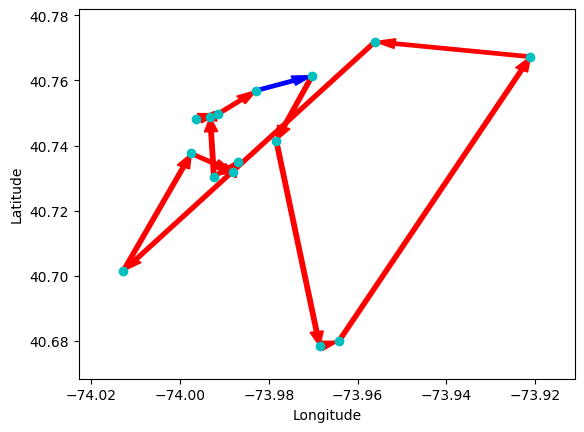

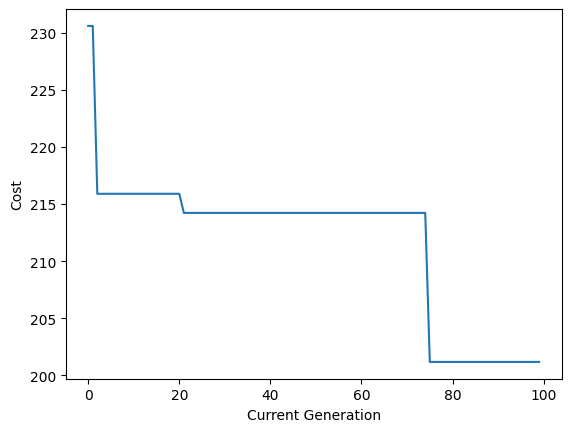

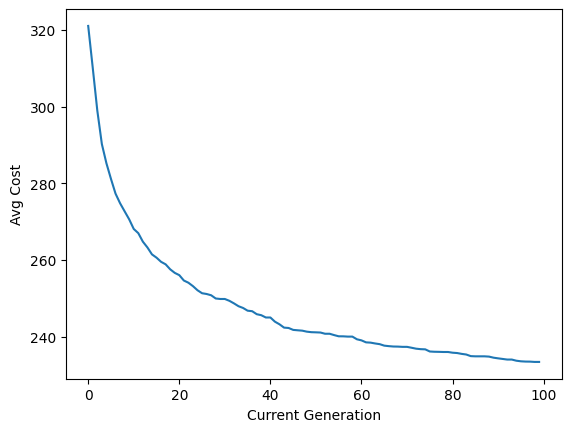

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pickle
import copy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import xgboost as xgb
import pprint


filename = "gdrive/My Drive/Meta Heuristic/xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
geolocator = Nominatim(user_agent="aco-application")


def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 11,
                  'pickup_minute': 0,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]


def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))


def total_cost_from_path(path):
    """
    Calculate the time (in minutes) to travel a path
    using the trained XGB model
    """
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    return total_cost

n = 100  # population size
mutation = 0.5 # mutation factor
crossover = 0.7  # crossover rate
loc_count = 15
generations = 100

locations = []
points = []
# Read in the user specified number of lines from the test data
df = pd.read_csv('gdrive/My Drive/Meta Heuristic/test.csv')[:loc_count]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))

# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)


# Initialize the population based on population size n
population = []
for i in range(n):
    new_path = [j for j in range(loc_count)]
    random.shuffle(new_path)
    population.append(new_path)

# Lists used for plotting at the end
x_values = [i for i in range(generations)]
y_values = []
avg_costs = []

best_cost = 0
best_path = []

# Begin main loop to find candidate answer
for g in range(generations):
    # Store the generation's best costs
    g_star = []
    # Iterate through each path in population
    for i in range(n):
        # Mutation
        # Select a random path, not including current
        indicies = [j for j in range(n)]
        indicies.remove(i)
        mutant_index = int(random.sample(indicies, 1)[0])
        mutant_candidate = population[mutant_index]

        # Swap indicies based on mutation rate
        mutated_path = []
        for d in range(loc_count):
            if random.random() <= mutation and d > 0:
                mutated_path.append(mutated_path[d-1])
                mutated_path[d-1] = mutant_candidate[d]
            else:
                mutated_path.append(mutant_candidate[d])

        # Crossover
        # Create candidate path by crossing over with mutant
        curr_element = population[i]
        candidate = []
        for d in range(loc_count):
            # Roll for chance to crossover value
            if random.random() <= crossover:
                candidate.append(mutated_path[d])
            else:
                candidate.append(curr_element[d])

        # Remove duplicate indicies
        candidate = list(dict.fromkeys(candidate))
        # Find missing indicies
        missing_indicies = []
        for d in range(loc_count):
            if d not in candidate:
                missing_indicies.append(d)

        # Merge candidate with shuffled missing indicies
        random.shuffle(missing_indicies)
        candidate += missing_indicies

        # Selection
        # Select parent based on smaller path cost
        candidate_cost = total_cost_from_path(candidate)
        curr_cost = total_cost_from_path(curr_element)

        if candidate_cost < curr_cost:
            population[i] = copy.copy(candidate)
            g_star.append(candidate_cost)
        else:
            g_star.append(curr_cost)

    best_cost = min(g_star)
    y_values.append(best_cost)
    avg_costs.append(np.mean(g_star))
    best_path = population[g_star.index(best_cost)]
    if "store_true":
        print("Generation #" + str(g+1) + " best cost:",
              best_cost, "path:", best_path)

print("Min cost mean:", np.mean(y_values))
print("Min cost standard deviation:", np.std(y_values))

print('Final cost: {} minutes, path: {}'.format(best_cost, best_path))

# Print out final addresses in solution
if "store_true":
    print("Final path addresses:")
    try:
        addresses = []
        for p in best_path:
            addresses.append(geolocator.reverse(
                f"{points[p][1]}, {points[p][0]}").address)
        pprint.pprint(addresses)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed with message {e}")

# Plot out the results
x = []
y = []
for point in points:
    x.append(point[0])
    y.append(point[1])
plt.plot(x, y, 'co')

for _ in range(1, len(best_path)):
    i = best_path[_ - 1]
    j = best_path[_]
    plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
              color='r', length_includes_head=True)

# Close the loop and highlight the last and first point path
i = best_path[-1]  # Last point index
j = best_path[0]  # First point index
plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
          color='b', length_includes_head=True)

zoom_factor = 0.01
plt.xlim(min(x) - zoom_factor, max(x) + zoom_factor)
plt.ylim(min(y) - zoom_factor, max(y) + zoom_factor)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('Genetic Evolution Path.png')
plt.show()


plt.ylabel("Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, y_values)
plt.savefig('Best Cost vs Generation of GE.png')
plt.show()


plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.savefig('Avg Cost vs Generation of GE.png')
plt.show()

